Q. is the decoding accuracy better for expected vs unexpected trials?

Methods:
1. apply NPS ROI mask dpINS
2. extract patterns and classify based on expect/unexpect trials
3. calcualate accuracy and f1 scores
4. 




In [77]:
import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py


from nilearn import image, masking, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker


import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nntdata

from surfplot import Plot
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline



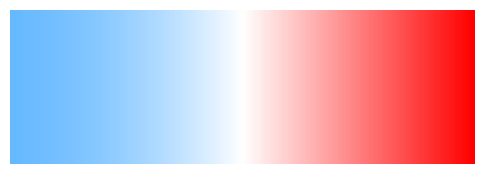

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
# Define the colors at specific points
colors = [
    # (0, "#120041"),  # Start with blue at -1.9
    # (0, "#2500fa"),
    (0, "#84c6fd"),  # Start with blue at -1.9
    (0.33, "white"),    # Transition to white at 0
    # (0.6, "#ffa300"),
    # (0.4, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (0, to_rgba("#120041", alpha=1.0)),  # Fully opaque
    # (0, to_rgba("#2500fa", alpha=0.8)),  # Fully opaque
    (0, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0.33, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.6, to_rgba("#ffa300", alpha=1.0)),   # 30% opacity
    # (0.4, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.0, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0, 1, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()



## load nifti files

# load data

* filenames are saved in metadata `.json`
* single trial extracted voxel weights are stored in `.npy`
* these files were generated using 
    * `scripts/step12_multiclass/mask_singletrial.py` <br>
    * `scripts/step12_multiclass/mask_singletrial.sh`

In [79]:
data_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv02_parcel-NPS'
npy_nps = np.load(join(data_dir, "npspos_rdpINS_event-stimulus.npy"))
npy_nps_metadata = join(data_dir, "npspos_rdpINS_event-stimulus.json")
with open(npy_nps_metadata, 'r') as file:
    npy_nps_meta = json.load(file)


singletrial_fname = npy_nps_meta['filenames']
npspos_dpINS = pd.DataFrame({'singletrial_fname': singletrial_fname})

def extract_metadata(filename):
    pattern = re.compile(
        r"(?P<sub>sub-\d+)_"
        r"(?P<ses>ses-\d+)_"
        r"(?P<run>run-\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"(?P<trial>trial-\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimulusintensity>\w+)"
    )
    match = pattern.search(filename)
    if match:
        
        metadata = match.groupdict()
        metadata['cue'] = metadata['cuetype'] + '_cue'
        metadata['stim'] = metadata['stimulusintensity'] + '_stim'
        return metadata
    
    return {}
# extract metadata from filenames and store into pandas columns ________________
metadata_df = pd.DataFrame(npspos_dpINS['singletrial_fname'].apply(extract_metadata).tolist())
metadata_df = pd.concat([metadata_df, npspos_dpINS], axis=1)

# append single trial voxel weights into pandas ________________________________
prefix = "NPSpos_dpINS_"
columns = [prefix + str(i) for i in range(npy_nps.shape[1])]
arraydf = pd.DataFrame(npy_nps, columns=columns)

npspos_dpINS = pd.concat([metadata_df, arraydf], axis=1)

In [80]:
npspos_dpINS.head()

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSpos_dpINS_22,NPSpos_dpINS_23,NPSpos_dpINS_24,NPSpos_dpINS_25,NPSpos_dpINS_26,NPSpos_dpINS_27,NPSpos_dpINS_28,NPSpos_dpINS_29,NPSpos_dpINS_30,NPSpos_dpINS_31
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,-0.313443,0.290236,0.581210,1.225067,-0.014961,0.647941,0.654115,1.402737,-0.004928,0.755369
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,-0.210200,-0.361020,-0.459746,-0.540654,-0.317410,-0.330051,-0.482609,-0.492325,-0.412294,-0.312559
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,0.590968,1.192717,0.069269,0.593420,0.359438,1.098236,0.423763,0.970760,0.344690,1.154257
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,0.524329,0.326208,0.706072,0.673848,0.958836,0.763788,0.607311,0.720266,0.942605,0.785004
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,0.725307,1.040514,0.732293,0.834235,0.695147,1.008251,0.676224,0.655942,0.611785,0.822074


In [81]:
# Define the mapping
mapping = {'high_stim': 0, 'med_stim': 1, 'low_stim': 2}
npspos_dpINS['stim_num'] = npspos_dpINS['stim'].map(mapping)


# dpINS average activation

Let's check if there is intensity separation in the classes. <br>
Given that dpINS and dpINS are one of the regions that decode stimulus intnsity with high accuracy, <br>
we ought to see clear distinctions in the average barplots. 

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=

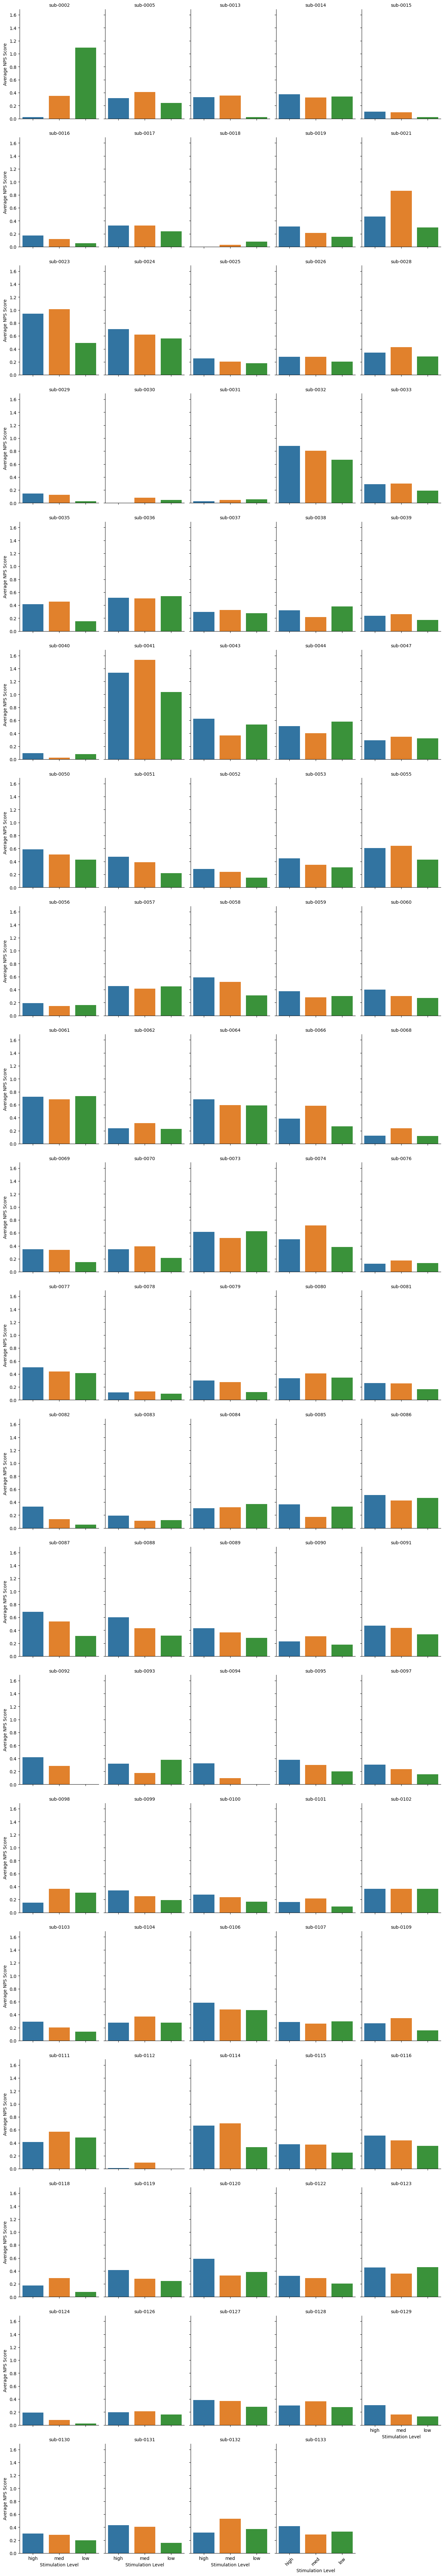

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cuetype='high_cue'
df_pain_index = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') 
                                    ].index
df_pain = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') 
                                ].copy().reset_index(drop=True)

# Step 1: Compute the row-wise mean of the NPS scores __________________________
df_pain['NPS_mean'] = df_pain.filter(regex=r'^NPSpos_dpINS_\d+').mean(axis=1)

# Step 2: Aggregate data to compute the mean NPS score per 'stim' for each 'sub'
grouped_data = df_pain.groupby(['sub', 'stimulusintensity'])['NPS_mean'].mean().reset_index()

# Step 3: Adjust order of 'stim' levels ________________________________________
stim_order = ['high', 'med', 'low']
grouped_data['stimulusintensity'] = pd.Categorical(grouped_data['stimulusintensity'], categories=stim_order, ordered=True)

# Step 4: Plot _________________________________________________________________
g = sns.catplot(x='stimulusintensity', y='NPS_mean', col='sub', data=grouped_data, kind='bar',
                height=4, aspect=.7, col_wrap=5, order=stim_order)

# Optional: Adjust plot aesthetics
g.set_axis_labels("Stimulation Level", "Average NPS Score")
g.set_titles("{col_name}")
g.set(ylim=(0, grouped_data['NPS_mean'].max()*1.1)) # Adjust y-axis limits if necessary
plt.xticks(rotation=45) # Rotate x-axis labels if needed

plt.show()


## expected vs unexpected

In [83]:
ratings = pd.read_csv('/Users/h/Documents/projects_local/cue_expectancy/data/beh/sub-all_task-all_events.tsv', sep = '\t')
ratings

def parse_filename_with_regex_adjusted(filename):
    # Updated regular expression pattern to keep the prefixes in the extracted values
    pattern = r"(sub-\d+)_(ses-\d+)_(run-\d+)_runtype-(\w+)_event-(\w+)_trial-(\d+)_cuetype-(\w+)_stimintensity-(\w+)"
    match = re.match(pattern, filename)
    
    if match:
        metadata = {
            'sub': match.group(1),  # Keeping the prefix for sub
            'ses':  match.group(2),  # Adding 'ses-' prefix
            'run':  match.group(3),  # Adding 'run-' prefix
            'runtype': match.group(4),
            'event': match.group(5),
            'trial_index': int(match.group(6)),  # Convert trial_index to integer
            'cue': match.group(7) + '_cue',  # Append "_cue" to cue value
            'stimulusintensity': match.group(8),  # Append "_stim" to stimulusintensity value
        }
        return metadata
    else:
        return {}

# Test the adjusted function with the sample filename
ratings_parsed = (ratings['singletrial_fname']).apply(parse_filename_with_regex_adjusted).apply(pd.Series)
rating_merge = pd.concat([ratings[['singletrial_fname', 'expectrating', 'outcomerating']], ratings_parsed], axis=1)

npspos_dpINS['trial_index'] = npspos_dpINS['trial'].str.extract('(\d+)').astype(int)

brain_metadf = pd.merge(rating_merge, npspos_dpINS, on=[ "sub", "ses", "run", "runtype", "trial_index", "cue", "stimulusintensity"], how="inner")

In [84]:
npspos_dpINS

,sub,ses,run,runtype,event,trial,cuetype,stimulusintensity,cue,stim,...,NPSpos_dpINS_24,NPSpos_dpINS_25,NPSpos_dpINS_26,NPSpos_dpINS_27,NPSpos_dpINS_28,NPSpos_dpINS_29,NPSpos_dpINS_30,NPSpos_dpINS_31,stim_num,trial_index
0,sub-0002,ses-03,run-02,pain,stimulus,trial-009,high,high,high_cue,high_stim,...,0.581210,1.225067,-0.014961,0.647941,0.654115,1.402737,-0.004928,0.755369,0,9
1,sub-0002,ses-04,run-05,cognitive,stimulus,trial-010,low,med,low_cue,med_stim,...,-0.459746,-0.540654,-0.317410,-0.330051,-0.482609,-0.492325,-0.412294,-0.312559,1,10
2,sub-0002,ses-04,run-02,cognitive,stimulus,trial-005,low,low,low_cue,low_stim,...,0.069269,0.593420,0.359438,1.098236,0.423763,0.970760,0.344690,1.154257,2,5
3,sub-0002,ses-04,run-05,cognitive,stimulus,trial-006,low,high,low_cue,high_stim,...,0.706072,0.673848,0.958836,0.763788,0.607311,0.720266,0.942605,0.785004,0,6
4,sub-0002,ses-03,run-03,cognitive,stimulus,trial-007,high,high,high_cue,high_stim,...,0.732293,0.834235,0.695147,1.008251,0.676224,0.655942,0.611785,0.822074,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17106,sub-0133,ses-04,run-02,pain,stimulus,trial-008,high,high,high_cue,high_stim,...,0.471928,0.611671,0.569393,0.602940,0.292355,0.694454,0.444390,0.647739,0,8
17107,sub-0133,ses-04,run-03,vicarious,stimulus,trial-008,low,med,low_cue,med_stim,...,0.391156,0.879472,0.427540,0.908208,0.540677,0.887672,0.635562,1.023007,1,8
17108,sub-0133,ses-03,run-04,cognitive,stimulus,trial-000,high,low,high_cue,low_stim,...,0.223640,0.203910,0.233194,0.221986,0.519530,0.395636,0.506916,0.396624,2,0
17109,sub-0133,ses-03,run-05,vicarious,stimulus,trial-001,high,med,high_cue,med_stim,...,0.060537,-0.127595,0.069507,0.034400,0.412281,0.108882,0.411141,0.251791,1,1


# 1 combined cues

Number of unique subjects dropped: 3
[1 2 1 2 0 1 0 1 2 2 0 2 0 0 1 2 0 1 2 0 1 0 0 1 1 2 0 2 2 0 1 1 2 2 2 2 2
 1 1 1 2 0 0 1 0 1 0 0]
[2 0 1 1 2 1 2 0 0 1 0 1 0 2 1 1 0 2 1 1 0 2 1 0 0 2 2 2 0 2 1 2 1 2 0 2 1
 1 2 0 1 2 1 0 0 0 0 2]
[1 1 0 1 0 1 0 2 1 0 1 2 0 2 2 2 2 0 2 1 0 2 1 0 0 2 1 1 1 0 2 2 0 0 2 2 2
 0 1 2 0 1 1 1 1 2 0 0]
[0 2 2 0 1 0 2 1 1 2 1 0 0 2 1 0 1 2 0 1 1 2 2 0]
[0 2 1 0 0 0 2 1 2 1 2 0 0 1 0 2 2 1 2 2 0 2 0 2 0 0 1 1 0 0 0 1 2 0 0 2 1
 2 1 0 0 2 1 2 1 1 2 1 1 1 1 2 2 0 1]
[1 2 2 0 1 0 0 2 2 2 2 1 0 1 1 1 0 0 1 0 2 2 0 1]
[0 0 1 1 2 1 1 2 0 0 2 1 2 2 0 1 0 2 2 0 2 2 2 0 2 1 2 0 0 0 2 1 2 1 1 0 1
 0 0 2 2 0 1 0 1 1 1 1]
[1 0 1 2 0 2 1 2 1 2 2 0 1 0 1 1 0 0 1 0 2 1 1 0 1 2 0 2 0 2 0 0 2 1 2 2]
[1 0 2 2 0 0 1 0 1 1 1 1 2 2 2 0 2 2 0 0 2 0 2 2 0 1 0 2 0 1 2 2 0 0 1 2 1
 1 1 0 0 1 2 1 1 1 2 0]
[0 2 2 1 2 1 2 0 1 0 1 2 1 1 1 2 0 0 1 0 1 0 0 2 1 2 1 2 2 1 0 0 2 2 0 0 0
 2 0 2 0 2 1 1 0 0 1 1 2 0 0 2 2 1 1 0 2 1 1 1 0 2 2 1 1 1 2 0 2 0 0]
[1 1 0 1 2 0 2 2 2 1 1 2 0 2 2 2 1 2

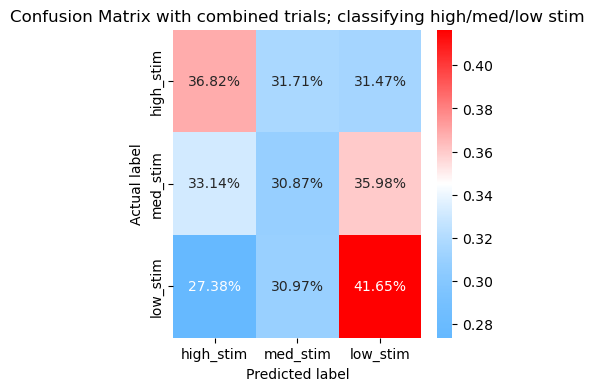

In [85]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd



# Step 1: subset pain data with high cue trials ________________________________
cue_pain_index = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') ].index
df_pain = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain')].copy().reset_index(drop=True)
# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
df_pain['ses_run'] =  df_pain['ses'] + '_' + df_pain['run'] 
unique_subs_before = df_pain['sub'].unique()
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain[~df_pain['sub'].isin(participants_to_exclude)]


# Step 3: How many subjects would be dropped after this filtering? _____________
unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")

# Step 4: group level arrays
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
group_confusion_matrices = []
desired_order = {'high_stim': 0, 'med_stim': 1, 'low_stim': 2}

# Step 5: Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dpINS_\d+').values
    Y_mapped = df_sub['stim'].map(desired_order)
    Y = Y_mapped.values
    uniques = np.array(['high_stim', 'med_stim', 'low_stim'])
    # Y, uniques = pd.factorize(df_sub['stim'])
    print(Y)
    # 5-1. subject wise items to save __________________________________________
    
    # accuracies = []
    # f1_scores = []
    test_indices = []
    predictions = []
    
    sub_true = []; sub_predictions = []; sub_accuracies = []; sub_f1_scores = []
    
    sub_confusion_matrices = [] 
    # 5-2. K fold per run (unique session/run combination) _____________________
    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # 5-3. Initialize and train the SVM model ______________________________
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')

        svc.fit(X_train, Y_train)#, groups_train) #, groups=groups_train)
        Y_pred = svc.predict(X_test)

        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))

        # 5-4. Store the test index and predictions ____________________________
        test_indices.extend(test_idx)
        cm = confusion_matrix(Y_test, Y_pred)
        cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

        sub_confusion_matrices.append(cv_cm_normalized)
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(sub_accuracies)     
    mean_f1_score = np.mean(sub_f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    # Aggregate the confusion matrices for this subject by summing them
    sub_cm_sum = np.mean(sub_confusion_matrices, axis=0)
    group_confusion_matrices.append(sub_cm_sum) # stack subject average Confusion matrix

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)
desired_class_order = ['high_stim', 'med_stim', 'low_stim']

# confution matrix
average_normalized_cm = np.mean(group_confusion_matrices, axis=0)
print("Normalized Confusion Matrix (by Actual Class Totals):")
print(average_normalized_cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(average_normalized_cm, 
            annot=True, fmt=".2%", cmap=cmap, 
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with combined trials; classifying high/med/low stim')
plt.show()

# Old method High cue

Number of unique subjects dropped: 28


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/_me

         sub  accuracy  f1_score
0   sub-0005       NaN       NaN
1   sub-0013       NaN       NaN
2   sub-0014       NaN       NaN
3   sub-0015       NaN       NaN
4   sub-0017       NaN       NaN
..       ...       ...       ...
62  sub-0128       NaN       NaN
63  sub-0129       NaN       NaN
64  sub-0130       NaN       NaN
65  sub-0131       NaN       NaN
66  sub-0133       NaN       NaN

[67 rows x 3 columns]


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/core/_me

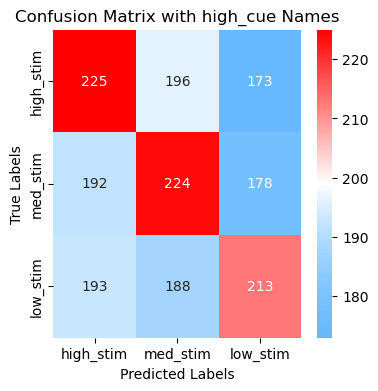

Normalized Confusion Matrix (by Actual Class Totals):
[[0.37878788 0.32996633 0.29124579]
 [0.32323232 0.37710438 0.2996633 ]
 [0.32491582 0.31649832 0.35858586]]


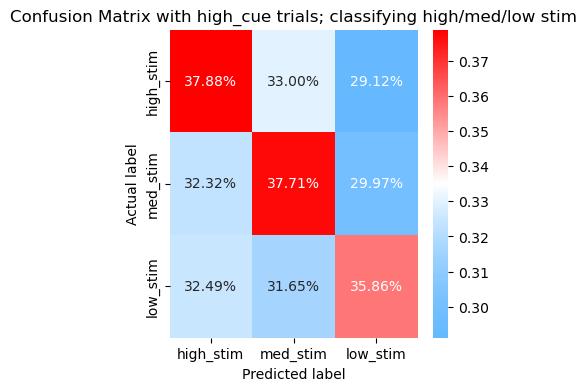

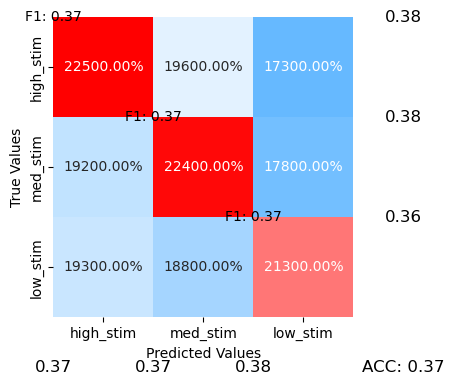

In [86]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd


# Step 1: subset pain data with high cue trials ________________________________
cuetype = 'high_cue'
high_cue_pain_index = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                    (npspos_dpINS['cue'] == cuetype)].index
df_pain_highcue = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                (npspos_dpINS['cue'] == cuetype)].copy().reset_index(drop=True)
unique_subs_before = df_pain_highcue['sub'].unique()

# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
# Ensure that for each subject (sub), within, each session-run combination (ses_run), 
# there are at least two trials for each level of stimulus intensity (stimulusintensity). 
# This step aims to exclude subjects or trials that don't meet this criterion, 
# ensuring a minimum level of data availability for each condition.
df_pain_highcue['ses_run'] =  df_pain_highcue['ses'] + '_' + df_pain_highcue['run'] 
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain_highcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain_highcue[~df_pain_highcue['sub'].isin(participants_to_exclude)]


# Step 3: How many subjects would be dropped after this filtering? _____________
# Print the number of subjects that do not have more than two trials per condition
# in every run
unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")


# Step 4: group level arrays ___________________________________________________
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
group_confusion_matrices = []


# Step 5: Iterate over each subject ____________________________________________
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dpINS_\d+').values
    Y, uniques = pd.factorize(df_sub['stim'])


    # 5-1. subject wise items to save __________________________________________
    # Initialization: Set up structures to store subject-specific metrics like 
    # accuracy and F1 scores, along with confusion matrices for later analysis.
    sub_accuracies = []
    accuracies = []
    f1_scores = []
    test_indices = []
    predictions = []
    sub_predictions = []
    sub_true = []
    sub_f1_scores = []
    sub_confusion_matrices = [] 


    # 5-2. K fold per run (unique session/run combination) _____________________
    # Group K fold based on run distinctions. Don't make the mistake of adding run 
    # or session as group distinctions. There are session/run combinations that
    # constitutes different runs
    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # 5-3. Initialize and train the SVM model ______________________________
        # subjectwise SVM - calculate accuracy, f1 score and save the true vs. 
        # predicted classes
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')
        svc.fit(X_train, Y_train)
        Y_pred = svc.predict(X_test)

        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))


        # 5-4. Store the test index and predictions ____________________________
        test_indices.extend(test_idx)
        # Calculate confusion matrix for the current fold and add it to the list
        cm = confusion_matrix(Y_test, Y_pred)
        sub_confusion_matrices.append(cm)
        
        # Predict and evaluate

        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
    # Store the mean accuracy for this subject
    mean_accuracy = np.mean(accuracies)     
    mean_f1_score = np.mean(f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    # Aggregate the confusion matrices for this subject by summing them
    sub_cm_sum = np.sum(sub_confusion_matrices, axis=0)
    sub_cm_normalized = sub_cm_sum / sub_cm_sum.sum(axis=1, keepdims=True)
    confusion_matrices.append(sub_cm_sum)

        # Normalize the summed confusion matrix for this subject
    with np.errstate(invalid='ignore', divide='ignore'):
        sub_cm_normalized = sub_cm_sum / sub_cm_sum.sum(axis=1, keepdims=True)
        sub_cm_normalized[np.isnan(sub_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

    group_confusion_matrices.append(sub_cm_normalized)

# Convert overall results to a DataFrame for easier analysis
results_df = pd.DataFrame(overall_results)
print(results_df)

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# _____________ confusion matrix ________________________________________________

# # The desired order for the classes
desired_class_order = [ 'high_stim', 'med_stim' , 'low_stim'
                       ]


# # Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


Y_test_remapped = np.vectorize(class_mapping.get)(all_Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(all_Y_pred)

cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)
# Calculate precision, recall, and F1 scores
precision, recall, f1, _ = precision_recall_fscore_support(Y_test_remapped, Y_pred_remapped, average=None)

# Calculate overall accuracy
accuracy = np.diag(cm).sum() / cm.sum()

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(cm, index=desired_class_order, columns=desired_class_order)


# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with {cuetype} Names')
plt.show()

from sklearn.metrics import confusion_matrix
import numpy as np


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row normalization

print("Normalized Confusion Matrix (by Actual Class Totals):")
print(cm_normalized)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap=cmap, xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()



# Create the heatmap
plt.figure(figsize=(5,5))

heatmap = sns.heatmap(conf_matrix_df, annot=True, fmt=".2%", cmap=cmap, 
                      cbar=False, xticklabels=desired_class_order, yticklabels=desired_class_order)

# Annotate with precision, recall, and F1
for i, label in enumerate(desired_class_order):
    heatmap.text(3.5, i, f"{recall[i]:.2f}", ha='center', va='center', fontsize=12)  # Recall per row
    heatmap.text(i, 3.5, f"{precision[i]:.2f}", ha='center', va='center', fontsize=12)  # Precision per column
    heatmap.text(i, i, f"F1: {f1[i]:.2f}", ha='center', va='center', color='black')  # F1 on the diagonal

# Annotate with overall accuracy
heatmap.text(3.5, 3.5, f"ACC: {accuracy:.2f}", ha='center', va='center', fontsize=12)

# Adjust layout to make room for the annotations
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.3)

# Labels for the true and predicted axes
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

plt.show()



# 2 High cue new confusion matrix scheme (high cue)

Number of unique subjects dropped: 28
Normalized Confusion Matrix (by Actual Class Totals):
[[0.40087065 0.26430348 0.33482587]
 [0.32997512 0.30422886 0.36579602]
 [0.29738806 0.31828358 0.38432836]]


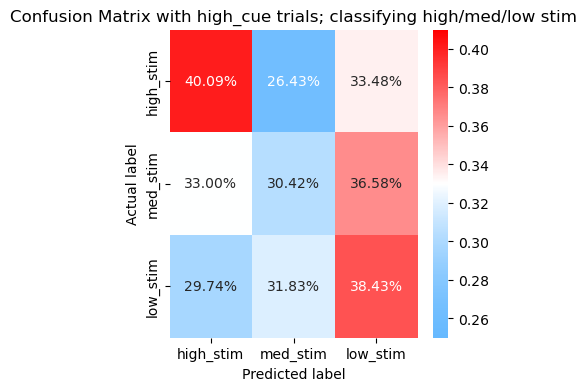

high cue f1score: 0.2978816236278922
high cue accuracy: 0.3631426202321725


In [97]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd



# Step 1: subset pain data with high cue trials ________________________________
cuetype = 'high_cue'
high_cue_pain_index = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                    (npspos_dpINS['cue'] == cuetype)].index
df_pain_highcue = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                (npspos_dpINS['cue'] == cuetype)].copy().reset_index(drop=True)


# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
# Ensure that for each subject (sub), within, each session-run combination (ses_run), 
# there are at least two trials for each level of stimulus intensity (stimulusintensity). 
# This step aims to exclude subjects or trials that don't meet this criterion, 
# ensuring a minimum level of data availability for each condition.

df_pain_highcue['ses_run'] =  df_pain_highcue['ses'] + '_' + df_pain_highcue['run'] 
unique_subs_before = df_pain_highcue['sub'].unique()
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain_highcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain_highcue[~df_pain_highcue['sub'].isin(participants_to_exclude)]


# Step 3: How many subjects would be dropped after this filtering? _____________
# Print the number of subjects that do not have more than two trials per condition
# in every run

unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")

# Step 4: group level arrays
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
group_confusion_matrices = []
desired_order = {'high_stim': 0, 'med_stim': 1, 'low_stim': 2}

# Step 5: Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dpINS_\d+').values
    Y_mapped = df_sub['stim'].map(desired_order)
    Y = Y_mapped.values
    uniques = np.array(['high_stim', 'med_stim', 'low_stim'])
    # Y, uniques = pd.factorize(df_sub['stim'])

    # 5-1. subject wise items to save __________________________________________
    # Initialization: Set up structures to store subject-specific metrics like 
    # accuracy and F1 scores, along with confusion matrices for later analysis.
    test_indices = []
    sub_true = []; sub_predictions = []; sub_accuracies = []; sub_f1_scores = []
    sub_confusion_matrices = [] 

    # 5-2. K fold per run (unique session/run combination) _____________________
    # Group K fold based on run distinctions. Don't make the mistake of adding run 
    # or session as group distinctions. There are session/run combinations that
    # constitutes different runs

    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
    
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # 5-3. Initialize and train the SVM model ______________________________
        # subjectwise SVM - calculate accuracy, f1 score and save the true vs. 
        # predicted classes
        svc = SVC(kernel='linear', probability=True, class_weight='balanced', decision_function_shape='ovr')

        svc.fit(X_train, Y_train)
        Y_pred = svc.predict(X_test)

        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))

        # 5-4. Store the test index and predictions ____________________________
        # Also, normalize the confusion matrix so that we can stack it per participant
        test_indices.extend(test_idx)
        labels = list(desired_order.values())
        cm = confusion_matrix(Y_test, Y_pred, labels=labels)
        cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Handle division by zero


        # cm = confusion_matrix(Y_test, Y_pred)
        # cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)
        # cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

        sub_confusion_matrices.append(cv_cm_normalized)

        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)

    # Step 6. Store the mean accuracy for this subject _________________________________
    mean_accuracy = np.mean(sub_accuracies)     
    mean_f1_score = np.mean(sub_f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    
    # Step 7. Aggregate the confusion matrices _________________________________
    # for a given subject, average the normalized confusion matrix and stack into
    # group variable group_confusion_matrices
    sub_cm_sum = np.mean(sub_confusion_matrices, axis=0)
    group_confusion_matrices.append(sub_cm_sum) # stack subject average Confusion matrix

# Step 8. Convert overall results to a DataFrame for easier analysis ___________
highcue_results_df = pd.DataFrame(overall_results)
# print(highcue_results_df)
desired_class_order = ['high_stim', 'med_stim', 'low_stim']

# Step 9. Plot confusion matrix ________________________________________________
average_normalized_cm = np.mean(group_confusion_matrices, axis=0)
print("Normalized Confusion Matrix (by Actual Class Totals):")
print(average_normalized_cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(average_normalized_cm, 
            annot=True, fmt=".2%", cmap=cmap, vmin=.25, vmax=.41,
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()


print(f"high cue f1score: {highcue_results_df['f1_score'].mean()}")
print(f"high cue accuracy: {highcue_results_df['accuracy'].mean()}")

In [88]:
highcue_results_df['accuracy'].mean()

0.3631426202321725

# 3 low cue (new method, CM per participant and average)

Number of unique subjects dropped: 30


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_24986/3902281815.py:105: RuntimeWarning: invalid value encountered in divide
  cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)


Normalized Confusion Matrix (by Actual Class Totals):
[[0.35346154 0.32012821 0.32641026]
 [0.34653846 0.34217949 0.31128205]
 [0.32025641 0.25935897 0.41782051]]


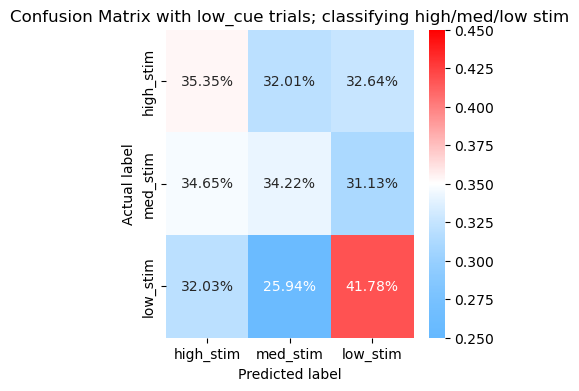

low cue f1score: 0.31713838013838014
low cue accuracy: 0.37179487179487175


In [95]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd



# Step 1: subset pain data with high cue trials ________________________________
cuetype = 'low_cue'
low_cue_pain_index = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                    (npspos_dpINS['cue'] == cuetype)].index
df_pain_lowcue = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                (npspos_dpINS['cue'] == cuetype)].copy().reset_index(drop=True)



# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
# Ensure that for each subject (sub), within, each session-run combination (ses_run), 
# there are at least two trials for each level of stimulus intensity (stimulusintensity). 
# This step aims to exclude subjects or trials that don't meet this criterion, 
# ensuring a minimum level of data availability for each condition.

df_pain_lowcue['ses_run'] =  df_pain_lowcue['ses'] + '_' + df_pain_lowcue['run'] 
unique_subs_before = df_pain_lowcue['sub'].unique()
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain_lowcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain_lowcue[~df_pain_lowcue['sub'].isin(participants_to_exclude)]



# Step 3: How many subjects would be dropped after this filtering? _____________
# Print the number of subjects that do not have more than two trials per condition
# in every run
unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")



# Step 4: group level arrays ___________________________________________________
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
group_confusion_matrices = []
desired_order = {'high_stim': 0, 'med_stim': 1, 'low_stim': 2}



# Step 5: Iterate over each subject ____________________________________________
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dpINS_\d+').values
    Y_mapped = df_sub['stim'].map(desired_order)
    Y = Y_mapped.values
    uniques = np.array(['high_stim', 'med_stim', 'low_stim'])
    # Y, uniques = pd.factorize(df_sub['stim'])

    # 5-1. subject wise items to save __________________________________________
    # Initialization: Set up structures to store subject-specific metrics like 
    # accuracy and F1 scores, along with confusion matrices for later analysis.
    test_indices = []
    sub_true = []; sub_predictions = []; sub_accuracies = []; sub_f1_scores = []
    sub_confusion_matrices = [] 

    # 5-2. K fold per run (unique session/run combination) _____________________
    # Group K fold based on run distinctions. Don't make the mistake of adding run 
    # or session as group distinctions. There are session/run combinations that
    # constitutes different runs

    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, Y, groups=groups):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        groups_train, groups_test = groups[train_idx], groups[test_idx]

        # 5-3. Initialize and train the SVM model ______________________________
        # subjectwise SVM - calculate accuracy, f1 score and save the true vs. 
        # predicted classes
        svc = SVC(kernel='linear', 
                  probability=True, 
                  class_weight='balanced', 
                  decision_function_shape='ovr')

        svc.fit(X_train, Y_train)
        Y_pred = svc.predict(X_test)

        sub_true.extend(Y_test)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test, Y_pred))
        sub_f1_scores.append(f1_score(Y_test, Y_pred, average='weighted'))

        # 5-4. Store the test index and predictions ____________________________
        # Also, normalize the confusion matrix so that we can stack it per participant
        test_indices.extend(test_idx)
        labels = list(desired_order.values())
        cm = confusion_matrix(Y_test, Y_pred, labels=labels)
        cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Handle division by zero

        sub_confusion_matrices.append(cv_cm_normalized)

        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)

    # Step 6. Store the mean accuracy for this subject _________________________
    mean_accuracy = np.mean(sub_accuracies)     
    mean_f1_score = np.mean(sub_f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    
    # Step 7. Aggregate the confusion matrices _________________________________
    # for a given subject, average the normalized confusion matrix and stack into
    # group variable group_confusion_matrices
    sub_cm_sum = np.mean(sub_confusion_matrices, axis=0)
    group_confusion_matrices.append(sub_cm_sum) # stack subject average Confusion matrix

# Step 8. Convert overall results to a DataFrame for easier analysis ___________
lowcue_results_df = pd.DataFrame(overall_results)
desired_class_order = ['high_stim', 'med_stim', 'low_stim']

# Step 9. Plot confusion matrix ________________________________________________
average_normalized_cm = np.mean(group_confusion_matrices, axis=0)
print("Normalized Confusion Matrix (by Actual Class Totals):")
print(average_normalized_cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(average_normalized_cm, 
            annot=True, fmt=".2%", cmap=cmap, vmin=.25, vmax=.41,
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()


print(f"low cue f1score: {lowcue_results_df['f1_score'].mean()}")
print(f"low cue accuracy: {lowcue_results_df['accuracy'].mean()}")

In [ ]:
print(f"low cue f1score: {lowcue_results_df['f1_score'].mean()}")
print(f"low cue accuracy: {lowcue_results_df['accuracy'].mean()}")

# 4 Shuffle

In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle as sklearn_shuffle



# Step 1: subset pain data with high cue trials ________________________________
cuetype = 'low_cue'
high_cue_pain_index = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                    (npspos_dpINS['cue'] == cuetype)].index
df_pain_lowcue = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                (npspos_dpINS['cue'] == cuetype)].copy().reset_index(drop=True)


# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
# Ensure that for each subject (sub), within, each session-run combination (ses_run), 
# there are at least two trials for each level of stimulus intensity (stimulusintensity). 
# This step aims to exclude subjects or trials that don't meet this criterion, 
# ensuring a minimum level of data availability for each condition.

df_pain_lowcue['ses_run'] =  df_pain_lowcue['ses'] + '_' + df_pain_lowcue['run'] 
unique_subs_before = df_pain_lowcue['sub'].unique()
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain_lowcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain_lowcue[~df_pain_lowcue['sub'].isin(participants_to_exclude)]


# Step 3: How many subjects would be dropped after this filtering? _____________
# Print the number of subjects that do not have more than two trials per condition
# in every run

unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")

# Step 4: group level arrays
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
group_confusion_matrices = []
desired_order = {'high_stim': 0, 'med_stim': 1, 'low_stim': 2}

# Assuming the rest of your setup code remains the same...

# Step 5: Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dpINS_\d+').values
    Y_mapped = df_sub['stim'].map(desired_order)
    Y = Y_mapped.values
    # Assuming uniques is defined as before
    uniques = np.array(['high_stim', 'med_stim', 'low_stim'])

    sub_confusion_matrices = [] 

    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, groups=groups):  # Note: Y is not used for splitting here
    
        # Shuffle labels within each fold, within each participant
        _, Y_shuffled = sklearn_shuffle(X[train_idx], Y[train_idx], random_state=None)  # Shuffles Y in train
        _, Y_test_shuffled = sklearn_shuffle(X[test_idx], Y[test_idx], random_state=None)  # Shuffles Y in test
        
        # Train and predict with the model as before
        svc.fit(X[train_idx], Y_shuffled)  # Use shuffled Y for training
        Y_pred = svc.predict(X[test_idx])  # Prediction step remains the same

        sub_true.extend(Y_test_shuffled)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test_shuffled, Y_pred))
        sub_f1_scores.append(f1_score(Y_test_shuffled, Y_pred, average='weighted'))

        # 5-4. Store the test index and predictions ____________________________
        test_indices.extend(test_idx)
        cm = confusion_matrix(Y_test_shuffled, Y_pred)
        cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

        sub_confusion_matrices.append(cv_cm_normalized)
        all_Y_test.extend(Y_test_shuffled)
        all_Y_pred.extend(Y_pred)

        # Generate confusion matrix using shuffled labels for computing the null distribution
        cm = confusion_matrix(Y_test_shuffled, Y_pred)  # Use Y_test_shuffled for confusion matrix
        cv_cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Handle division by zero if any

        sub_confusion_matrices.append(cv_cm_normalized)

    # Aggregate and process confusion matrices as before...

    # Step 6. Store the mean accuracy for this subject _________________________________
    mean_accuracy = np.mean(sub_accuracies)     
    mean_f1_score = np.mean(sub_f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    
    # Step 7. Aggregate the confusion matrices _________________________________
    # for a given subject, average the normalized confusion matrix and stack into
    # group variable group_confusion_matrices
    sub_cm_sum = np.mean(sub_confusion_matrices, axis=0)
    group_confusion_matrices.append(sub_cm_sum) # stack subject average Confusion matrix

# Step 8. Convert overall results to a DataFrame for easier analysis ___________
shuffle_df = pd.DataFrame(overall_results)
print(shuffle_df)
desired_class_order = ['high_stim', 'med_stim', 'low_stim']

# Step 9. Plot confusion matrix ________________________________________________
average_normalized_cm = np.mean(group_confusion_matrices, axis=0)
print("Normalized Confusion Matrix (by Actual Class Totals):")
print(average_normalized_cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(average_normalized_cm, 
            annot=True, fmt=".2%", cmap=cmap, vmin=.25, vmax=.45,
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()

print(f"shuffle_df f1score: {shuffle_df['f1_score'].mean()}")
print(f"shuffle_df accuracy: {shuffle_df['accuracy'].mean()}")

Number of unique subjects dropped: 30


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.

# high cue shuffle

Number of unique subjects dropped: 28
         sub  accuracy  f1_score
0   sub-0005  0.353175  0.293449
1   sub-0013  0.342040  0.284056
2   sub-0014  0.350939  0.293874
3   sub-0015  0.348174  0.289737
4   sub-0017  0.345556  0.285714
..       ...       ...       ...
62  sub-0128  0.340569  0.280083
63  sub-0129  0.337990  0.278035
64  sub-0130  0.337909  0.277562
65  sub-0131  0.337857  0.277410
66  sub-0133  0.340122  0.279820

[67 rows x 3 columns]
Normalized Confusion Matrix (by Actual Class Totals):
[[0.37077114 0.29589552 0.33333333]
 [0.335199   0.33855721 0.32624378]
 [0.34129353 0.35721393 0.30149254]]


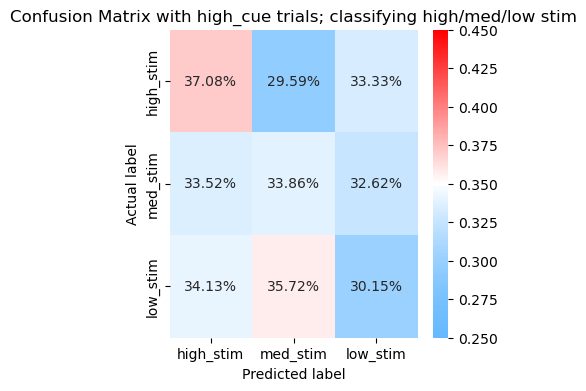

shuffle_df f1score: 0.2767948419786506
shuffle_df accuracy: 0.338700563058131


In [ ]:
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle as sklearn_shuffle



# Step 1: subset pain data with high cue trials ________________________________
cuetype = 'high_cue'
high_cue_pain_index = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                    (npspos_dpINS['cue'] == cuetype)].index
df_pain_lowcue = npspos_dpINS[(npspos_dpINS['runtype'] == 'pain') & 
                                (npspos_dpINS['cue'] == cuetype)].copy().reset_index(drop=True)


# Step 2: filter dataframe based on stimulus intensity trials per sub/ses ______
# Ensure that for each subject (sub), within, each session-run combination (ses_run), 
# there are at least two trials for each level of stimulus intensity (stimulusintensity). 
# This step aims to exclude subjects or trials that don't meet this criterion, 
# ensuring a minimum level of data availability for each condition.

df_pain_lowcue['ses_run'] =  df_pain_lowcue['ses'] + '_' + df_pain_lowcue['run'] 
unique_subs_before = df_pain_lowcue['sub'].unique()
# Correcting the approach to identify participants to exclude
filtered_groups = df_pain_lowcue.groupby(['sub', 'ses_run', 'stimulusintensity']).filter(lambda x: len(x) < 2)
participants_to_exclude = filtered_groups['sub'].unique()
filtered_df = df_pain_lowcue[~df_pain_lowcue['sub'].isin(participants_to_exclude)]


# Step 3: How many subjects would be dropped after this filtering? _____________
# Print the number of subjects that do not have more than two trials per condition
# in every run

unique_subs_after = filtered_df['sub'].unique()
subs_dropped = [sub for sub in unique_subs_before if sub not in unique_subs_after]
num_subs_dropped = len(subs_dropped)
print(f"Number of unique subjects dropped: {num_subs_dropped}")

# Step 4: group level arrays
runs_per_sub = filtered_df.groupby('sub')['run'].nunique()
subs_to_drop = runs_per_sub[runs_per_sub <= 1].index
df_filtered = filtered_df[~filtered_df['sub'].isin(subs_to_drop)]
confusion_matrices = []
overall_results = []
all_Y_test = []
all_Y_pred = []
group_confusion_matrices = []
desired_order = {'high_stim': 0, 'med_stim': 1, 'low_stim': 2}

# Assuming the rest of your setup code remains the same...

# Step 5: Iterate over each subject
for sub in df_filtered['sub'].unique():
    df_sub = df_filtered[df_filtered['sub'] == sub]
    X = df_sub.filter(regex=r'^NPSpos_dpINS_\d+').values
    Y_mapped = df_sub['stim'].map(desired_order)
    Y = Y_mapped.values
    # Assuming uniques is defined as before
    uniques = np.array(['high_stim', 'med_stim', 'low_stim'])

    sub_confusion_matrices = [] 

    groups, unique_runs = pd.factorize(df_sub['ses_run'])
    cv = GroupKFold(n_splits=len(np.unique(groups)))
    
    for train_idx, test_idx in cv.split(X, groups=groups):  # Note: Y is not used for splitting here
    
        # Shuffle labels within each fold, within each participant
        _, Y_shuffled = sklearn_shuffle(X[train_idx], Y[train_idx], random_state=None)  # Shuffles Y in train
        _, Y_test_shuffled = sklearn_shuffle(X[test_idx], Y[test_idx], random_state=None)  # Shuffles Y in test
        
        # Train and predict with the model as before
        svc.fit(X[train_idx], Y_shuffled)  # Use shuffled Y for training
        Y_pred = svc.predict(X[test_idx])  # Prediction step remains the same

        sub_true.extend(Y_test_shuffled)
        sub_predictions.extend(Y_pred)
        sub_accuracies.append(accuracy_score(Y_test_shuffled, Y_pred))
        sub_f1_scores.append(f1_score(Y_test_shuffled, Y_pred, average='weighted'))

        # 5-4. Store the test index and predictions ____________________________
        test_indices.extend(test_idx)
        cm = confusion_matrix(Y_test_shuffled, Y_pred)
        cv_cm_normalized = cm / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Replace NaNs with 0s if any row sum was 0

        sub_confusion_matrices.append(cv_cm_normalized)
        all_Y_test.extend(Y_test_shuffled)
        all_Y_pred.extend(Y_pred)

        # Generate confusion matrix using shuffled labels for computing the null distribution
        cm = confusion_matrix(Y_test_shuffled, Y_pred)  # Use Y_test_shuffled for confusion matrix
        cv_cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cv_cm_normalized[np.isnan(cv_cm_normalized)] = 0  # Handle division by zero if any

        sub_confusion_matrices.append(cv_cm_normalized)

    # Aggregate and process confusion matrices as before...

    # Step 6. Store the mean accuracy for this subject _________________________________
    mean_accuracy = np.mean(sub_accuracies)     
    mean_f1_score = np.mean(sub_f1_scores)
    overall_results.append({'sub': sub, 
                            'accuracy': mean_accuracy, 
                            'f1_score': mean_f1_score})
    
    # Step 7. Aggregate the confusion matrices _________________________________
    # for a given subject, average the normalized confusion matrix and stack into
    # group variable group_confusion_matrices
    sub_cm_sum = np.mean(sub_confusion_matrices, axis=0)
    group_confusion_matrices.append(sub_cm_sum) # stack subject average Confusion matrix

# Step 8. Convert overall results to a DataFrame for easier analysis ___________
shuffle_df = pd.DataFrame(overall_results)
print(shuffle_df)
desired_class_order = ['high_stim', 'med_stim', 'low_stim']

# Step 9. Plot confusion matrix ________________________________________________
average_normalized_cm = np.mean(group_confusion_matrices, axis=0)
print("Normalized Confusion Matrix (by Actual Class Totals):")
print(average_normalized_cm)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(average_normalized_cm, 
            annot=True, fmt=".2%", cmap=cmap, vmin=.25, vmax=.45,
            xticklabels=desired_class_order, 
            yticklabels=desired_class_order)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix with {cuetype} trials; classifying high/med/low stim')
plt.show()

print(f"shuffle_df f1score: {shuffle_df['f1_score'].mean()}")
print(f"shuffle_df accuracy: {shuffle_df['accuracy'].mean()}")